# Analysis Pipeline

In this notebook I created a valid pipeline that inputs topology and trajectory files and aims to output useful metrics and plots that will help us capture a differentiating signal **between agonists and antagonists**.

The **flow** in general is:

1. **Input**: A directory of 2 subdirectories (agonists and antagonists)
2. Read the files (currently using [MDAnalysis](https://www.mdanalysis.org/) and [MDTraj](http://mdtraj.org/1.9.3/))
3. Apply methods and measurements (Radius of Gyration, RMSD, RMSF, SASA, PCA)
4. **Output**: Metrics, plots and conclusions

**Tools used**:
* [MDAnalysis](https://www.mdanalysis.org/), offering parsing and analysis MD trajectories
* [MDtraj](http://mdtraj.org/latest/index.html), complementary analysis methods of MDAnalysis
* [GROMACS](http://www.gromacs.org/), performing and analyzing MD simulations
* [VDM](https://www.ks.uiuc.edu/Research/vmd/), protein and trajectory visualization tool

Currently in the dataset we have:
* 10 agonists
* 13 antagonists

The simulations are of 500ns window with 2.500 frames.

TODOs (TO BE REMOVED):
* Write general method for averaging the cols of the features
* Wrtie getters of features that check if they have been computed 

In [1]:
import MDAnalysis
from MDAnalysis.analysis.rms import RMSF
import MDAnalysis.analysis.pca as pca

import mdtraj as md_traj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os
import subprocess
import logging
import math
from tqdm.notebook import tqdm
from IPython.display import display

## The AnalysisActor class

The class will be responsible for reading, running analysis methods and storing the results.
Explanation of the metrics, useful plots and conclusion can be found on later stages of the notebook.

In [2]:
class AnalysisActor:
    '''
    The AnalysisActor object inputs a single topology and trajectory and performs the analysis
    A full list of input formats: https://www.mdanalysis.org/docs/documentation_pages/coordinates/init.html#supported-coordinate-formats
    
    Args:
        topology (str): The topology file (.pdb, .gro etc)
        trajectory (str): The trajectory file (.xtc etx)
        drug_name (str): The name of the agonist or antagonist
        
    Attributes:
        uni: The universe of atoms created by MDAnalysis tool
        mdtraj: The trajectory of atoms created by MDTraj tool
        name (str): The simulation name (extracted by the topology file)
        rg_res (List[double]): Radius of gyration of each frame
        rmsf_res (List[double]): RMSF of each residue
        pca_res (Object: MDAnalysis.analysis.pca.PCA): Object containing eigenvectors and eigenvalues
                                                       of CA atoms covariance matrix
        sasa_res (np.array[2, #frames]): The calculation currently is performed outside of the pipeline 
                                          using gromacs. MDTraj offers an algorithm for calculating SASA 
                                          but is computationally intensive and cannot run on my laptop
    '''
    
    def __init__(self, topology, trajectory, drug_name, sasa_file=""):
        self.uni = MDAnalysis.Universe(topology, trajectory)
#         self.mdtraj = md_traj.load(trajectory, top=topology) # Currently not used
        self.drug_name = drug_name
        self.rg_res = []
        self.rmsf_res = None
        self.pca_res = None
        self.sasa_res = self.__read_sasa_file(sasa_file) if sasa_file != "" else np.arange(1)
        
        
    def __read_sasa_file(self, sasa_filepath):
        '''
        Private method that helps us parse the sasa.xvg file generated by `gmx sasa -f trajectory.xtc -s topology.tpr -o sasa.xvg`
        and and stores them into a numpy array
        
        Args:
            sasa_filepath (str): Filepath of the .xvg file to read
            
        Returns:
            np.array[2, #frames], eg [[0, 1, 2, ... , n], [SASA0, SASA1, SASA2, ..., SASAn]]
        '''
        sasa_list = []
        p = re.compile('\s+([0-9\.]*)\s+([0-9\.]*)\\n')    # RegEx to extract the frame, SASA pair of each frame

        with open(sasa_filepath) as fp:
            Lines = fp.readlines() 
            for line in Lines:
                if(line[0] != '#' and line[0] != '@'):    #Ignore the GROMACS comment lines
                    m = p.match(line)
                    sasa_list.append([m.group(1), m.group(2)]) # Group1: Frame, Group2: SASA

        sasa_list_arr = np.array(sasa_list).T.astype('float64') # Cast to numpy array and transpose
        return sasa_list_arr
    
        
    def info():
        ''' Prints basic info of the universe of atoms '''
        print(f'\n<<< Info of {self.name} >>>')
        print(f'\tNumber of Frames: {len(self.uni.trajectory)}')
        print(f'\tNumber of Atoms: {len(self.uni.atoms)}')
        print(f'\tNumber of Residues: {len(self.uni.residues)}')
    
    
    def get_frames_number(self):
        ''' Returns the number of frames of the trajectory '''
        return len(self.uni.trajectory)
    
    
    def perform_analysis(self, metrics=[]):
        '''
        Runs the analysis methods for calculating the metrics specified by metrics argument
        
        Args:
            metrics (List[str]): A list of the metrics to be calculated. Available:
                                 Empty List []: All of the available metrics
                                 'Rg': Radius of Gyration
                                 'RMSF': Root Mean Square Fluctuations
                                 'SASA': Solven Accesible Surface Area
                                 'PCA': Principal Component Analysis
        '''
        
        # Calculate Radius of Gyration as time progresses
        if "Rg" in metrics or len(metrics) == 0:
            for frame in self.uni.trajectory:
                self.rg_res.append(self.uni.atoms.radius_of_gyration())
                
        # Calculate Solvent Accesible Surface Area 
        if "SASA" in metrics or len(metrics) == 0:
            # self.sasa_res = md_traj.shrake_rupley(self.mdtraj) # Cannot calculate on my laptop
            if self.sasa_res.shape == (1,):
                logging.warning(f'No sasa.xvg generated by GROMACS was found in the {self.drug_name} directory')
            
        # Calculate Root Mean Square Fluctuation
        if "RMSF" in metrics or len(metrics) == 0:
            # TODO: Look more into alignemnt step
            self.rmsf_res = RMSF(self.uni.atoms).run()

        # Perform PCA on the CA atoms
        if "PCA" in metrics or len(metrics) == 0:
            self.pca_res = pca.PCA(self.uni, select='name CA')
            self.pca_res.run()
        

## Reading the trajectories

Emphasis must be given on reading the trajectory files in an organized and optimal way.
The current approach is:

1. Input: path wich points to a directory that contains to subdirectories with names **"agonists", "antagonists"**
2. Extract the filepaths of trajectory.xtc, topology.pdb and sasa.xvg (if available)
3. Create the dictionary:
```python 
{
    "Agonists": List[DirectoryPath (str), AnalysisActor.class]
    "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
}
```
   
**The trajectory and topology file are expected to have a file ending of .xtc and .pdb respectively,
although we can easily expand it to more formats**


In [3]:
root_directory = '../datasets/New_AI_MD/'

dir_list = os.listdir(root_directory)
if 'Agonists' not in dir_list: logging.error('Agonists directory not found')
if 'Antagonists' not in dir_list: logging.error('Antagonists directory not found')

analysis_actors_dict = {"Agonists":[], "Antagonists":[]}

# Iterating through the directories tree in order to fill the analysis_actors_dict
# A warning is thrown when reading the Lorcaserin 
for which_dir in ['Agonists', 'Antagonists']:
    simulations = os.listdir(root_directory + which_dir + '/')
    for which_sim in tqdm(simulations, desc=which_dir):
        files = os.listdir(root_directory + which_dir + '/' + which_sim + '/')
        top = ""
        traj = ""
        sasa_filepath = ""
        for file in files:
            if file[-4:] == ".xtc":
                traj = root_directory + which_dir + '/' + which_sim +'/' + file
            elif file[-4:] == ".pdb":
                top = root_directory + which_dir + '/' + which_sim +'/' + file
            elif file == 'sasa.xvg':
                # Currently SASA is calculated using GROMACS before running this notebok
                sasa_filepath = root_directory + which_dir + '/' + which_sim +'/' + file
        if traj == "" or top == "":
            logging.error("Failed to find topology or trajectory file in: " + root_directory + which_dir + '/' + which_sim +'/' + file)
        else:
            analysis_actors_dict[which_dir].append([root_directory + which_dir + '/' + which_sim + '/',
                                                    AnalysisActor(top, traj, which_sim, sasa_file=sasa_filepath)])
            

/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:259: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:260: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:261: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:264: RuntimeWarning: invalid value encountered in greater
  if np.all(box > 0.0) and alpha < 180.0 and beta < 180.0 and gamma < 180.0:


## Performing the Calculations

Having read all of the trajectories and topology files we must calculate some features that will help us do our analysis.

Currently the calculations include:
* Radius of Gyration (MDAnalysis)
* RMSF (MDAnalysis)
* PCA (MDAnalysis)
* SASA (GROMACS, but MDTraj has an [available method](http://mdtraj.org/latest/api/generated/mdtraj.shrake_rupley.html#mdtraj.shrake_rupley) that was too intensive for my laptop) 

In [4]:
# The calculations are perfomed by calling the 'perform_analysis' method of our AnalysisActor objects

# Agonists
for which_actor in tqdm(analysis_actors_dict['Agonists'], desc="Agonists Calculations"):
    which_actor[1].perform_analysis()
    
# Antagonists
for which_actor in tqdm(analysis_actors_dict['Antagonists'], desc="Antagonists Calculations"):
    which_actor[1].perform_analysis()

## Evaluating the Performance

Having created our `AnalysisActor` objects for all of our drugs (agonists and antagonists) we must know interpret the results through useful visualizations.
Our main goal is to be able to find a signal that differentiates an antagonist from an agonist.

An **agonist** binds to the receptor and produces an effect within the cell. An **antagonist** may bind to the same receptor, but does not produce a response, instead it blocks that receptor to a natural agonist [(ref)](https://www.sciencedirect.com/science/article/abs/pii/S1472029906003845).


*Many of the plots would fail if the simulations were not of the same length (number of frames). If needed we can easily fix it by adding padding when required.*

In [15]:
# General info about future plots
total_plots = len(analysis_actors_dict['Agonists']) + len(analysis_actors_dict['Antagonists'])
plot_cols = 3
plot_rows = math.ceil(total_plots / plot_cols)


### Radius of Gyration


Radius of gyration is an indicator of protein structure compactness. It is concerned with how regular secondary structures are compactly packed into 3D structure of protein. α proteins have the highest radius of gyration throughout the protein size range considered, suggesting a less tight packing as compared with β-and (α + β)-proteins. The lowest radius of gyration and, accordingly, the tightest packing are a characteristic of α/β-proteins [(ref)](https://www.researchgate.net/publication/226987521_Radius_of_gyration_as_an_indicator_of_protein_structure_compactness).
If a protein is stably folded, it will likely maintain a relatively steady value of Rg. If a protein unfolds, its Rg will change over time [(ref)](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0112456&type=printable).

\begin{equation*}
Rg^2 = \sum_{i=1}^N m_i\left( r_i - R_c \right)^2 
\end{equation*}

$R_c$ the center of mass (excluding hydrogens)  
$r_i$ the coordinates of the i_th atom  
$m_i$ the mass of the ith atom.

#### Separate Plots

Firstly, I plotted all of the agonists/antagonists $Rg$ seperately:

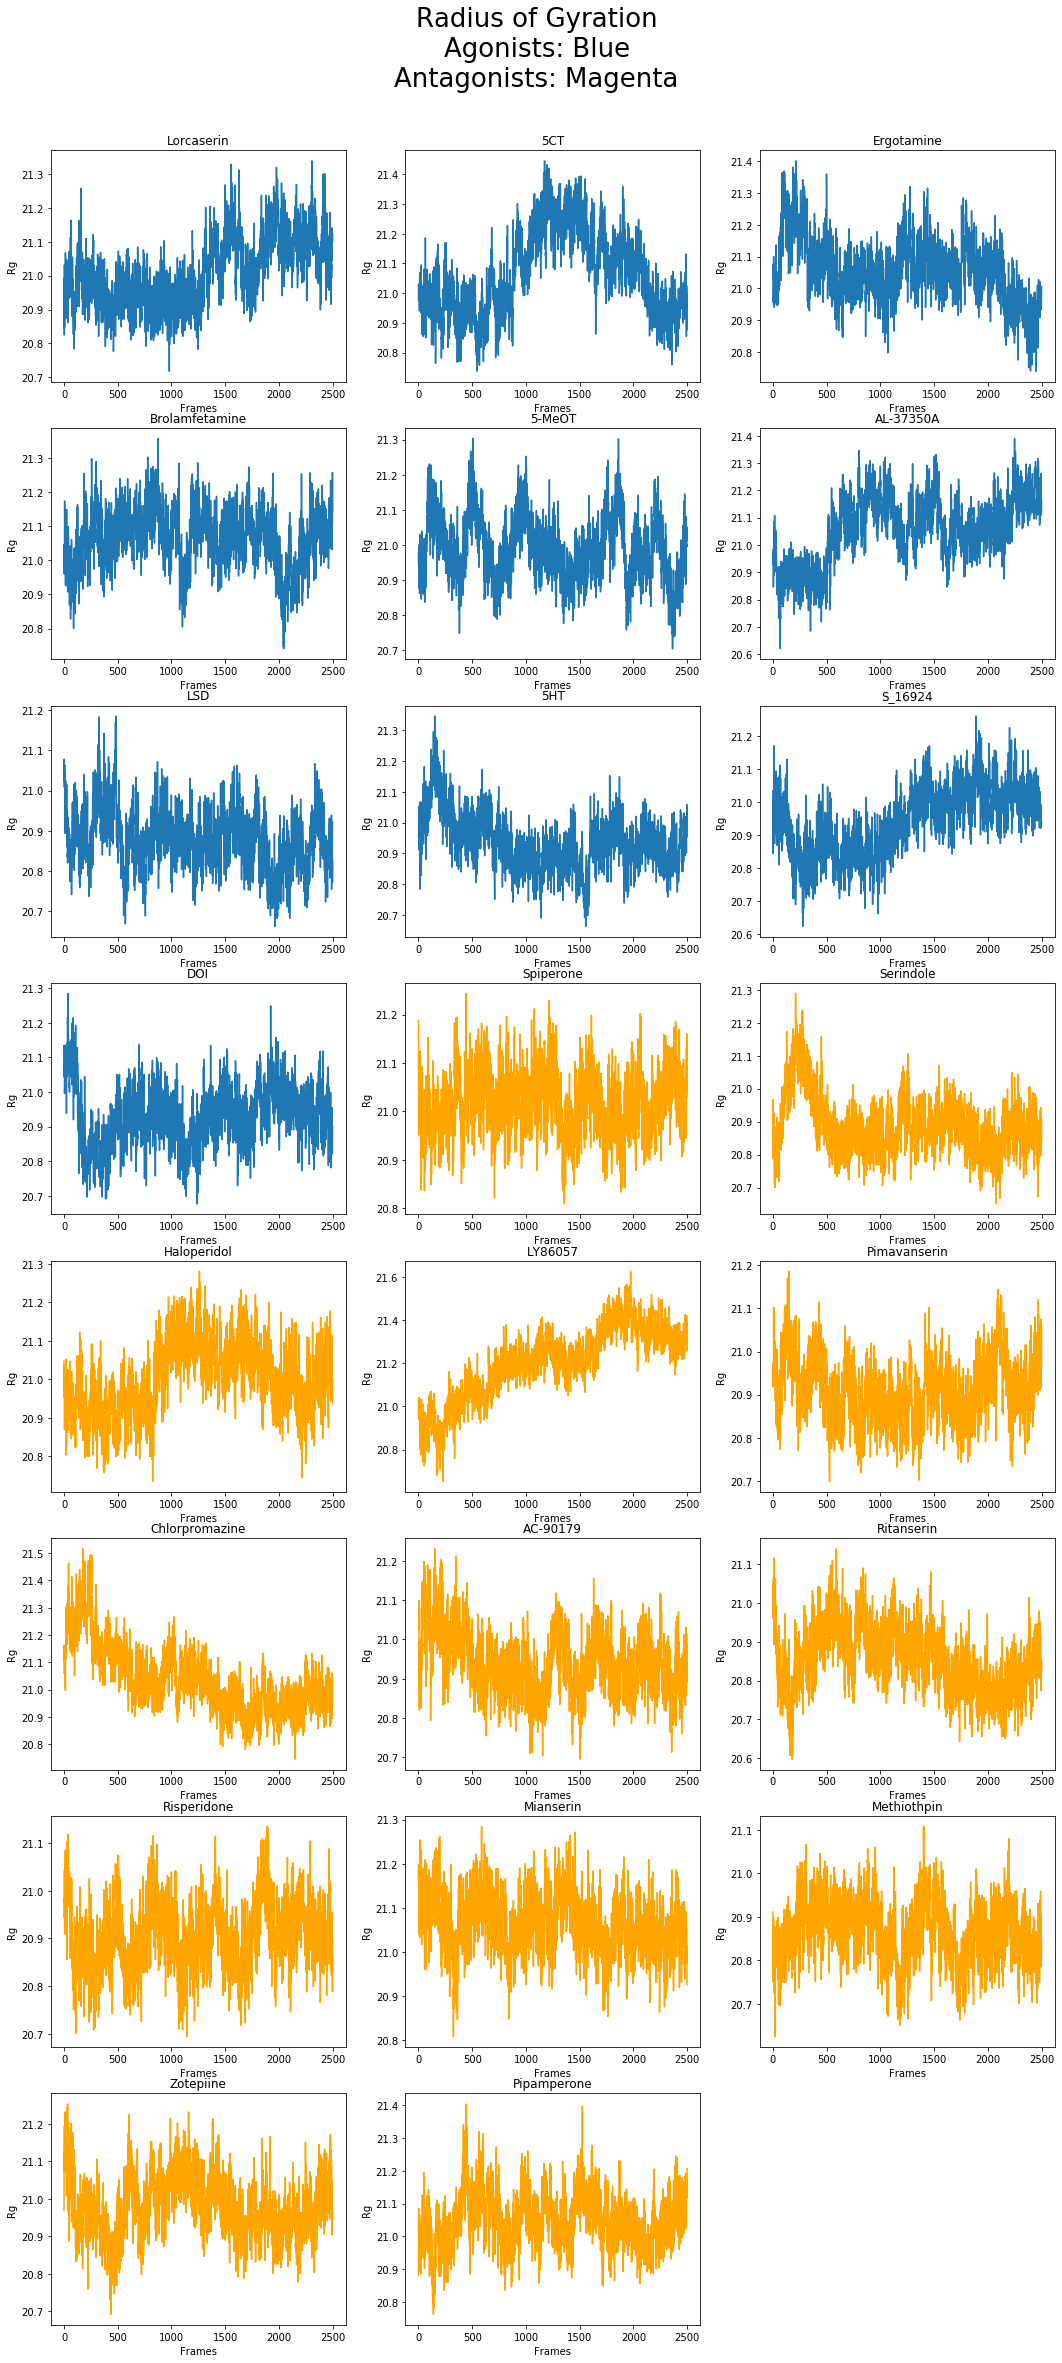

In [17]:
# We create plot of the Rg as frames progress for each drug
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].rg_res, label="Rg")
    plt.xlabel("Frames")
    plt.ylabel("Rg")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].rg_res, label="Rg", color='orange')
    plt.xlabel("Frames")
    plt.ylabel("Rg")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Radius of Gyration\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)

plt.show()

#### Frame Averaged Plot

To have more intuition if $Rg$ has any important signal for differentiating agonists/antagonists:
1. Create an **average** Rg of each frame of the **agonists**
2. Create an **average** Rg of each frame of the **antagonists**
3. Plot them on the same figure

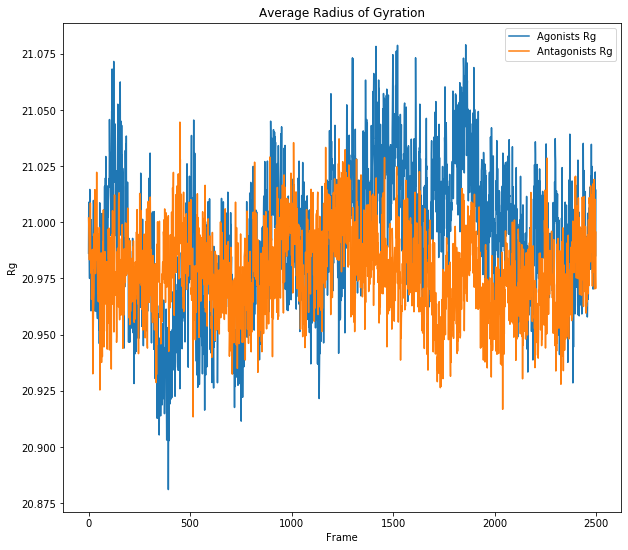

In [7]:
def calculate_average_cols_rg(analysis_actors_dict):
    '''
    Calculates the mean of Rg of each frame for all the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    stacked_agonists = analysis_actors_dict['Agonists'][0][1].rg_res
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, which_drug[1].rg_res))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    stacked_antagonists = analysis_actors_dict['Antagonists'][0][1].rg_res
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, which_drug[1].rg_res))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)

agon_rg_avg, antagon_rg_avg = calculate_average_cols_rg(analysis_actors_dict)

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(111)
ax.plot(np.arange(agon_rg_avg.shape[0]), agon_rg_avg, label="Agonists Rg")
ax.plot(np.arange(agon_rg_avg.shape[0]), antagon_rg_avg, label="Antagonists Rg")
ax.set_ylabel('Rg')
ax.set_xlabel('Frame')

ax.legend()
plt.title("Average Radius of Gyration")
plt.show()


We observe the antagonists not having any great deviations from the average $Rg$ throughout the simulation. However, in the case of the agonists we observe a consistent increase of $Rg$ from frames 1300 - 2100 .

###  Solvent-Accesible Surface Area (SASA)
​  
The accessible surface area (ASA) or solvent-accessible surface area (SASA) is the surface area of a biomolecule that is accessible to a solvent [(ref)](http://compbio.biosci.uq.edu.au/mediawiki/upload/d/d5/Lee1971_JMolBiol55-379.pdf). Measurement of ASA is usually **described in units of square Ångstroms**. ASA is typically calculated using the 'rolling ball' algorithm developed by Shrake & Rupley in 1973. This algorithm uses a sphere (of solvent) of a particular radius to 'probe' the surface of the molecule [(ref)](https://www.sciencedirect.com/science/article/abs/pii/0022283673900119?via%3Dihub).
​  
​  
Changes of SASA indicate a change in the conformation of the protein and unfolding.

<img src="https://drive.google.com/uc?export=view&id=17CHp_-xbBPDuRM13SmvmCMpc4Y1i2jwS" alt="drawing" width="200"/>

*Currently the SASAs were calculated using **GROMACS** before running the notebook. There is a function module on MDTraj package that can be used but my laptop was not able to handle its memory usage. If they were not generated the plots below will fail*

#### Separate Plots

I opted to use the same workflow as I did with $Rg$. So firstly, I will create the separate plots and then combine them on the same plot using the average SASA of each frame.

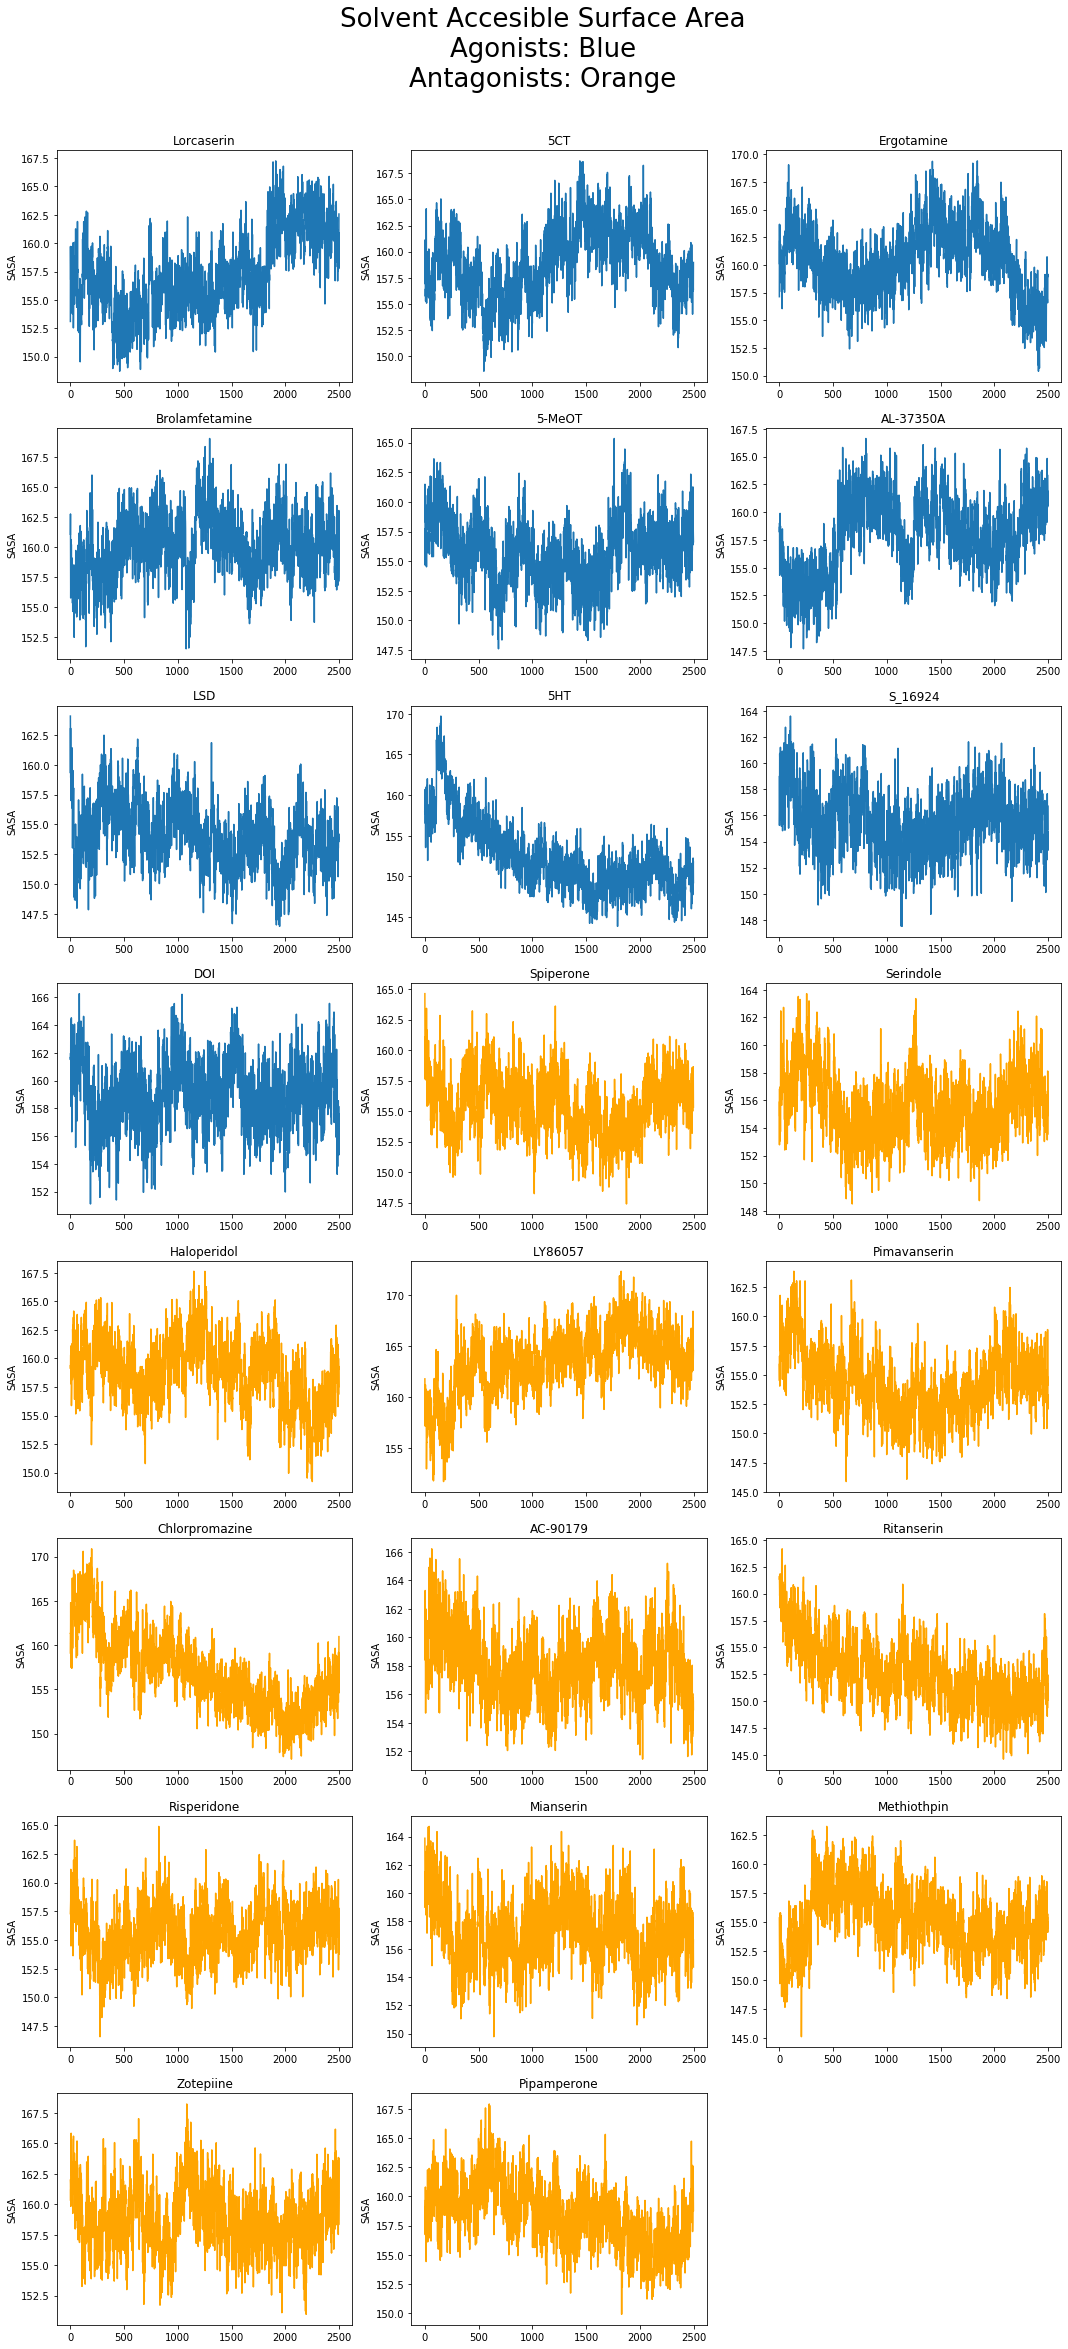

In [18]:
# We create plot of the SASA as frames progress for each drug
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].sasa_res[1], label="SASA")
    plt.ylabel("SASA")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].sasa_res[1], label="SASA", color='orange')
    plt.ylabel("SASA")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Solvent Accesible Surface Area\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)

plt.show()

#### Frame Averaged Plot

To have more intuition if **SASA** has any important signal for differentiating agonists/antagonists:
1. Create an **average** SASA of each frame of the **agonists**
2. Create an **average** SASA of each frame of the **antagonists**
3. Plot them on the same figure

*TODO: the `calculate_average_cols_metric` methods are similar and should be combined to one more general.* 

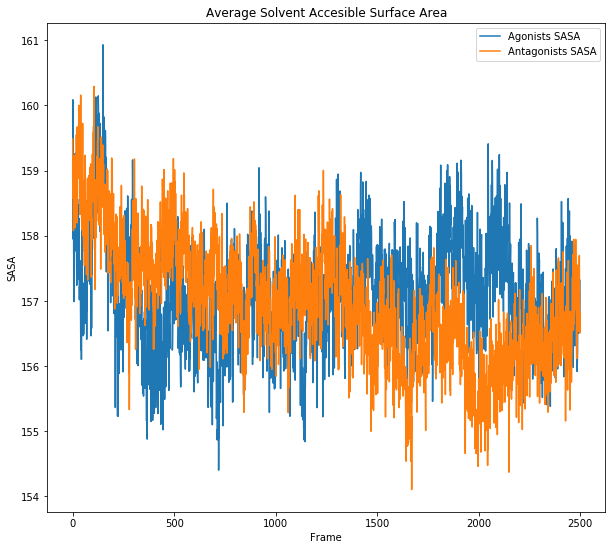

In [9]:
def calculate_average_cols_sasa(analysis_actors_dict):
    '''
    Calculates the mean of SASA of each frame for all the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    stacked_agonists = analysis_actors_dict['Agonists'][0][1].sasa_res[1]
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, which_drug[1].sasa_res[1]))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    stacked_antagonists = analysis_actors_dict['Antagonists'][0][1].sasa_res[1]
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, which_drug[1].sasa_res[1]))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)

agon_sasa_avg, antagon_sasa_avg = calculate_average_cols_sasa(analysis_actors_dict)

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(111)
ax.plot(np.arange(agon_sasa_avg.shape[0]), agon_sasa_avg, label="Agonists SASA")
ax.plot(np.arange(agon_sasa_avg.shape[0]), antagon_sasa_avg, label="Antagonists SASA")
ax.legend()
ax.set_ylabel('SASA')
ax.set_xlabel('Frame')
plt.title("Average Solvent Accesible Surface Area")
plt.show()

This time we observe the agonists have a small increase on their SASA (frames 1800 - 2200). However, this time we also observe the SASA of the antagonists decreasing (frames 1500 - 2200) showing an **inverse correlation** between the $Rg$ of the agonists and the SASA of the antagonists.

### Root Mean Square Flactuation (RMSF)

RMSF is a measure of the deviation of the position of a particle i with respect to a reference position **over time**.

**Difference between RMSD and RMSF**: The latter is averaged over time, giving a value for each particle i. For the RMSD the average is taken over the particles, giving time specific values. So **RMSD is time specific** and **RMSF is atom specific** [(ref)](http://www.drugdesign.gr/uploads/7/6/0/2/7602318/lecture_mdanalysis.pdf).

\begin{equation*}
RMSF_i = \left[ \frac{1}{T} \sum_{t_j=1}^T \mid r_i(t_j) - r_i^\text{ref} \mid ^ 2 \right] ^ \frac{1}{2}
\end{equation*}

$T$ is the total simulation time  
$r_i^\text{ref}$ is the reference position of particle $i$, like the **time-averaged** position of the same particle $i$  

This time since our $x-axis$ are the residues ids, we will have a slightly different approach.
Our $y-axis$ will have the RMSF value of each residue specified by the $x-axis$.
Other than that we will again have the same plots.

#### Separate Plots

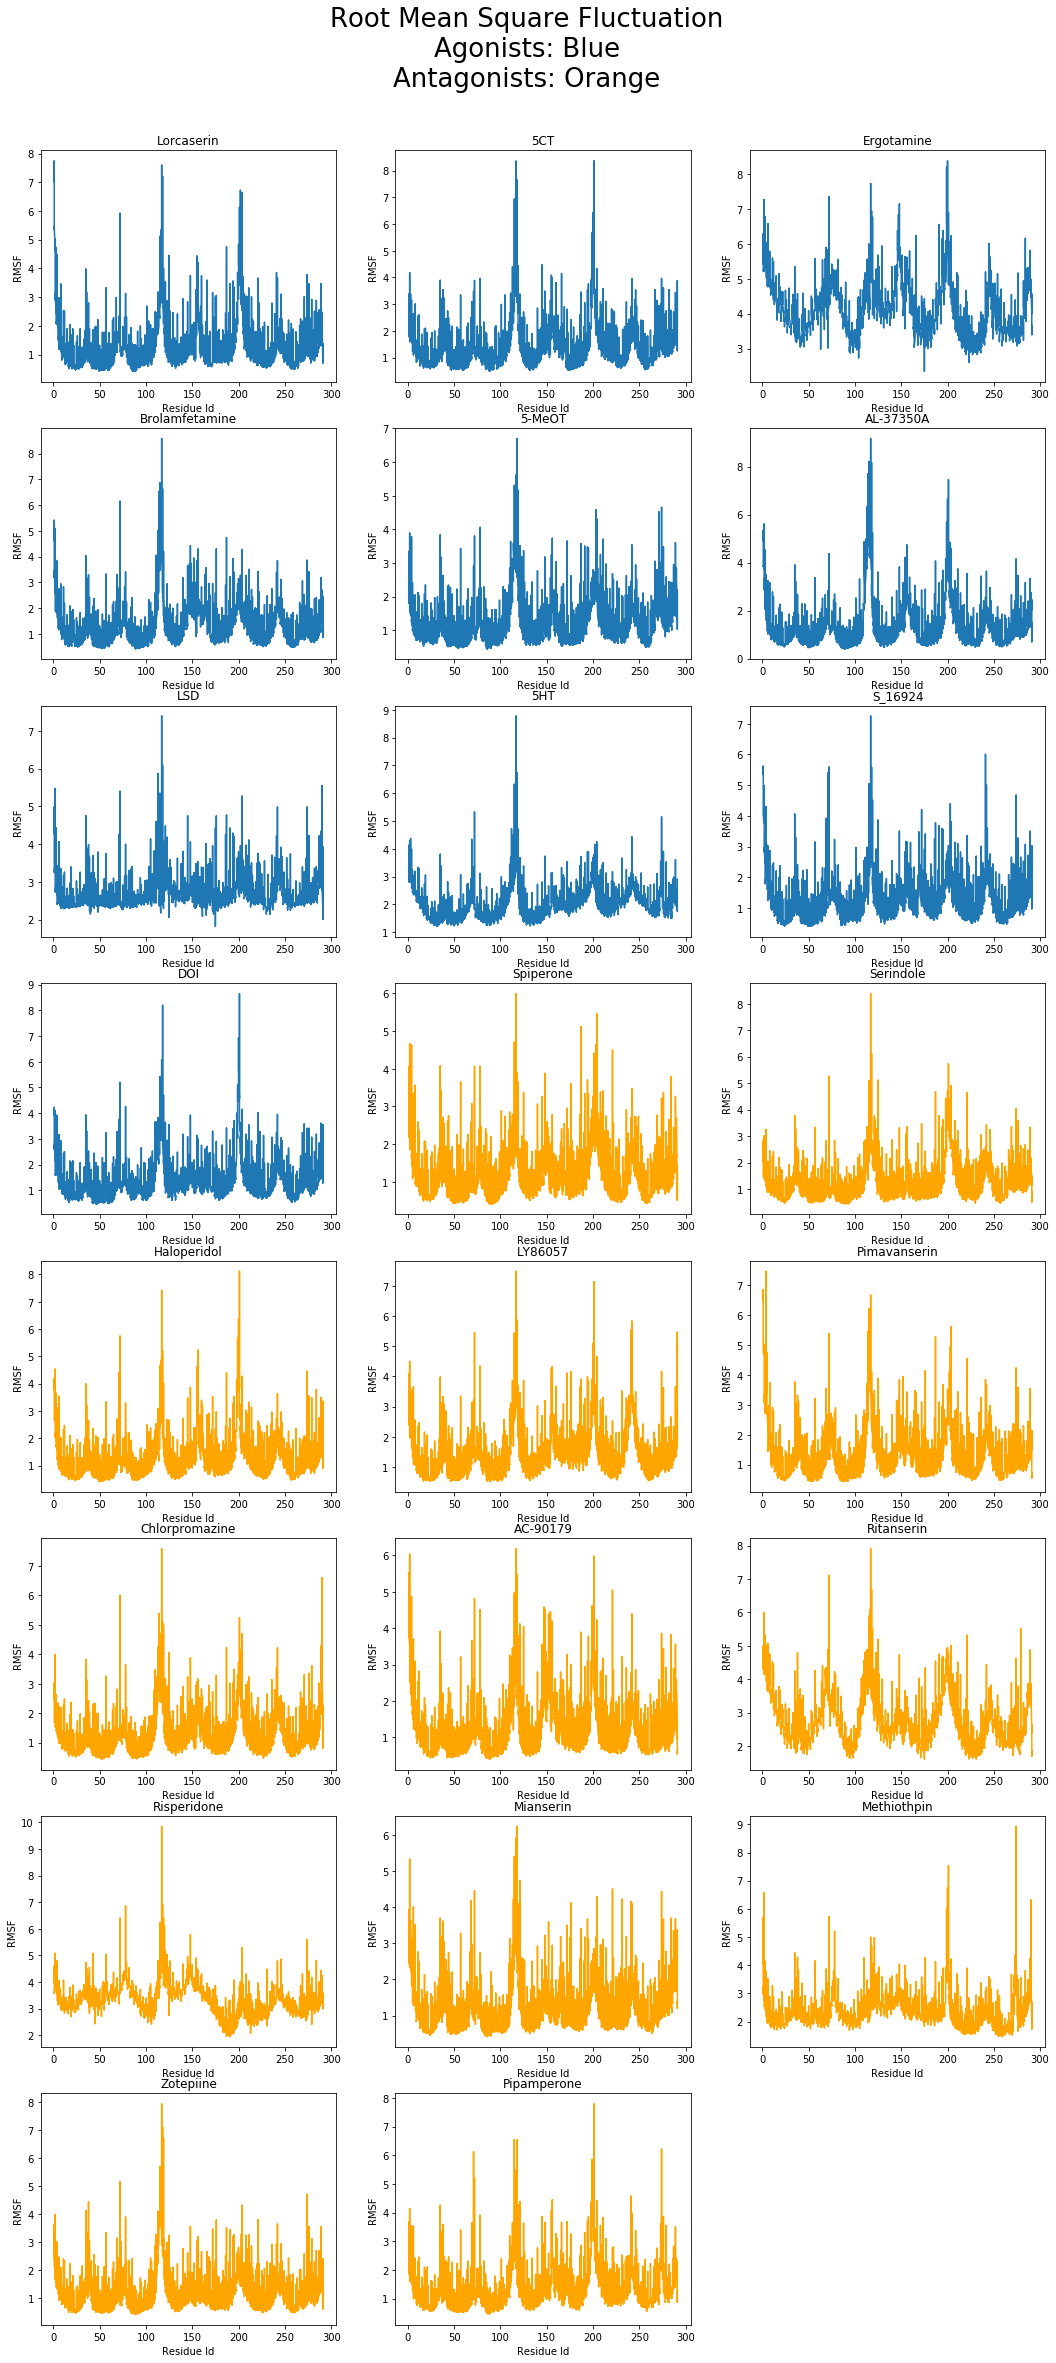

In [19]:
# We create plot of the RMSF as residue id progresses for each drug
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(which_drug[1].uni.atoms.resnums, which_drug[1].rmsf_res.rmsf, label="RMSF")
#     plt.plot(np.unique(which_drug[1].uni.atoms.resnums), get_avg_rmsf_per_residue(which_drug[1]), label="SASA")
    plt.xlabel("Residue Id")
    plt.ylabel("RMSF")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(which_drug[1].uni.atoms.resnums, which_drug[1].rmsf_res.rmsf, label="RMSF", color='orange')
    plt.xlabel("Residue Id")
    plt.ylabel("RMSF")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Root Mean Square Fluctuation\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)

plt.show()

#### Residue Averaged Plot

As with the previous plots we average the columns although in this case each column is not a frame but a residue.

Since the dimensions do not much (different number of atoms) I decided to firstly calculate the average RMSF of each residue (which are on all of the drugs 291).
Then I calculate the average RMSF of the residues of all the agonists and then all of the antagonists.

Steps:
1. Calculate for each drug the average RMSF of each residue -> Reduces dimensionality to 291
2. Calculate the average of the result on step 1 for all the agonists
3. Calculate the average of the result on step 1 for all the antagonists
3. Plot them on the same figure


Since the above is a bit complicated I will explain it **using an example**.

Let's say we have 5 agonists.
Each agonist has **k number of atoms** but **291 residues**.  
What residue each atom belongs is given by a vector like: $[1, 1, 1, 2, 2, ..., 291, 291]_k^T$  
We also have a vector of RMSFs of each atom like $[3, 2, 7, 5, 8, ..., 2, 5]_k^T$  
  
We then calculate the average RMSF of each residue. In the above example we will have $(3 + 2 + 7)/3$ for residue1    
Since we have 291 residues, this creates a vector of 291 values.  
We do this for all the agonists, stack them and calculate the average the same way we did on $Rg$ and SASA.

In [11]:
def get_avg_rmsf_per_residue(drug):
    '''
    Having the series of resnumbs eg [1, 1, 1, 2, 2, ..., 291, 291] and their respective
    RMSF crete buckets (each bucket represents a residue) and calculate the average 
    RMSF of each residue
    
    Args:
        drug (AnalysisActor.class): The AnalysisActor object on which we have calculated the RMSF
    
    Returns:
        np.array[#unique_resnumbs]: The average RMSF of each residue
    '''
    bucket = 0
    total_rmsf = np.zeros(len(np.unique(drug.uni.atoms.resnums)))    # Holds the sum of RMSFs of each residue
    total_atoms = np.zeros(len(np.unique(drug.uni.atoms.resnums)))   # Holds the number of atoms of each residue
    first_time = True
    for i in range(len(drug.uni.atoms.resnums)):
        if not first_time and drug.uni.atoms.resnums[i] != drug.uni.atoms.resnums[i - 1]:
            bucket += 1    # Changed residue -> go to next bucket
        elif first_time:
            first_time = False

        total_rmsf[bucket] += drug.rmsf_res.rmsf[i]
        total_atoms[bucket] += 1

    avg_rmsf_per_residue = total_rmsf / total_atoms    # Calculate the mean

    return avg_rmsf_per_residue

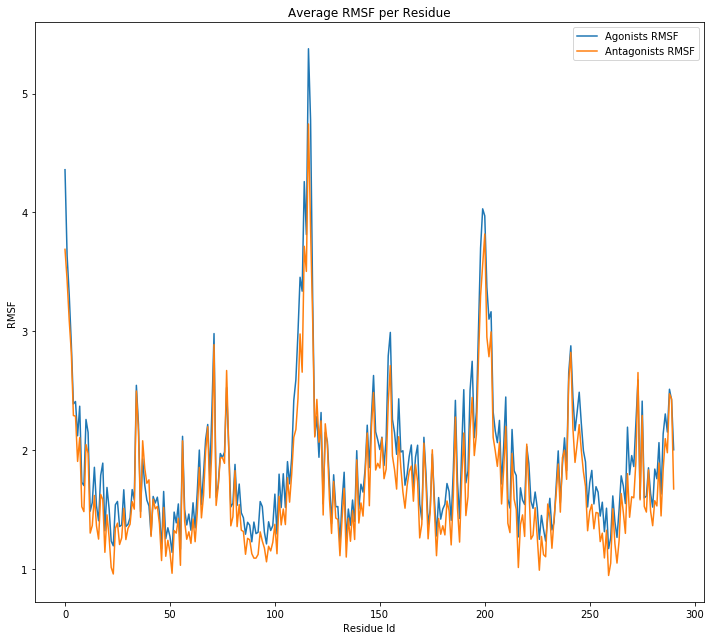

In [12]:
def calculate_average_cols_rmsf(analysis_actors_dict):
    '''
    Calculates the mean of the mean residue RMSF for the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    stacked_agonists = get_avg_rmsf_per_residue(analysis_actors_dict['Agonists'][0][1])
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, get_avg_rmsf_per_residue(which_drug[1])))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    stacked_antagonists = get_avg_rmsf_per_residue(analysis_actors_dict['Antagonists'][0][1])
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, get_avg_rmsf_per_residue(which_drug[1])))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)

agon_rmsf_residue_avg, antagon_rmsf_residue_avg = calculate_average_cols_rmsf(analysis_actors_dict)

fig = plt.figure(figsize=(10, 9))
x = np.arange(agon_rmsf_residue_avg.shape[0])
ax = plt.subplot(111)
ax.plot(np.arange(agon_rmsf_residue_avg.shape[0]), agon_rmsf_residue_avg, label="Agonists RMSF")
ax.plot(np.arange(agon_rmsf_residue_avg.shape[0]), antagon_rmsf_residue_avg, label="Antagonists RMSF")
ax.legend()
ax.set_ylabel('RMSF')
ax.set_xlabel('Residue Id')
plt.title("Average RMSF per Residue")
fig.tight_layout()
plt.show()

We observe that on average the RMSF of the agonists of almost all the residues is bigger than the one of the antagonists on the same residue. However the differences are small.

#### Top RMSF Residues

To extract more clear information of the above matrix we can find the residue ids that have the biggest RMSF on average.

In [14]:
# Top 10 RMSF residues
def return_top_k(input_arr, k=10):
    '''
    Returns a DataFrame of the top 10 values of the input array
    
    Args:
        input_arr (ndarray): A vector of the values we want to extract the top-k
    
    Returns:
        pd.DataFrame[Residue Id, RMSF]: A pandas dataframe, on the 1st column are the indexes of the top-k values
                                        and on the 2nd column the value
    '''
    ind = np.argpartition(input_arr, -k)[-k:]
    ind = ind[np.argsort(input_arr[ind])]

    arr = np.flip(ind)    # Flip the top10 indexes since we want descending order
    arr = np.stack((arr, np.array(input_arr[arr])))    # Stack the Residue Ids

    return pd.DataFrame(arr.T, columns=['Residue Id', 'RMSF'])    # Convert to dataframe for prettier print


print("Printing Top-10 Average RMSF Residues of Agonists")
print(return_top_k(agon_rmsf_residue_avg))

print("\nPrinting Top-10 Average RMSF Residues of Abs(Agonists_RMSF - Antagonists_RMSF)")
print(return_top_k(np.abs(agon_rmsf_residue_avg - antagon_rmsf_residue_avg)))

Printing Top-10 Average RMSF Residues of Agonists
   Residue Id      RMSF
0       116.0  5.378268
1       117.0  4.779240
2         0.0  4.359794
3       114.0  4.259641
4       199.0  4.030491
5       200.0  3.970790
6       115.0  3.813633
7       198.0  3.700432
8         1.0  3.635788
9       112.0  3.454124

Printing Top-10 Average RMSF Residues of Abs(Agonists_RMSF - Antagonists_RMSF)
   Residue Id      RMSF
0       117.0  0.917199
1       113.0  0.681858
2         0.0  0.670475
3       116.0  0.633329
4       111.0  0.555116
5       114.0  0.544710
6       112.0  0.477267
7       199.0  0.471025
8       201.0  0.420905
9       110.0  0.419546


**CARE: The indexing is 0 based on the above calculations, however on other tools like VMD may be 1 based.**

The above output tells us that residue-117 has the second greatest agonist average RMSF and the greatest difference between antagonists and agonists.  
  
Residue-117 or (118 on VMD) is **Phenylalanine (PHE)**. Through a quick search [(ref)](https://en.wikipedia.org/wiki/Phenylalanine), we find that:

>L-Phenylalanine is biologically converted into L-tyrosine, another one of the DNA-encoded amino acids. L-tyrosine in turn is converted into L-DOPA, which is further converted into dopamine, norepinephrine (noradrenaline), and epinephrine (adrenaline). The latter three are known as the catecholamines.

>Phenylalanine uses the same active transport channel as tryptophan to cross the blood–brain barrier. In excessive quantities, supplementation can interfere with the production of serotonin and other aromatic amino acids as well as nitric oxide due to the overuse (eventually, limited availability) of the associated cofactors, iron or tetrahydrobiopterin.
  
I believe that this shows us that we could use the RMSF to narrow our search and feature space allowing us more computational intensive studies like the progression of atom pairwise distances. 

### Principal Component Analysis (PCA)

PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly **uncorrelated variables** called principal components.  
PCA is employed on MD analysis to reveal **the most important motions in proteins**. PCA is a linear transformation that extracts the most important elements in the data using a covariance matrix or a correlation matrix (normalized PCA) constructed from atomic coordinates that describe the accessible Degrees Of Freedom of the protein, such as the Cartesian coordinates that define atomic displacements in each conformation (frame) comprising a trajectory.

**Cartesian Coordinate Based PCA** [(ref including analysis of PCA results)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4676806/pdf/nihms739932.pdf):  
1. Remove overall translations and rotation by aligning each frame to a reference structure
2. Choose a set of atoms for the analysis (eg alpha carbons)
3. Center the variables (row centering). Currently we have a $3m x n$ matrix ($m$ selected atoms, $n$ frames)
4. Construct the covariance matrix $3mx3m$
5. Diagonalize the covariance matrix
6. Examine the scree plot to determine  the number of eigenvectors to include in the reduced vector space that describes the most relevant features
7. Examine component loadings which give us the percent of variance by the PCs

#### Scree Plots

I first plot the scree plots to examine the variance acquired for each component used.  
I perform PCA for computational reasons on CA atoms. On future runs I will run PCA on the whole protein that will take much more time (if at all feasible on my laptop).  
I am plotting the variance given by the **first 50 components** to have a better visual understanding, since the variance added by is almost 0 for the rest of the components. 

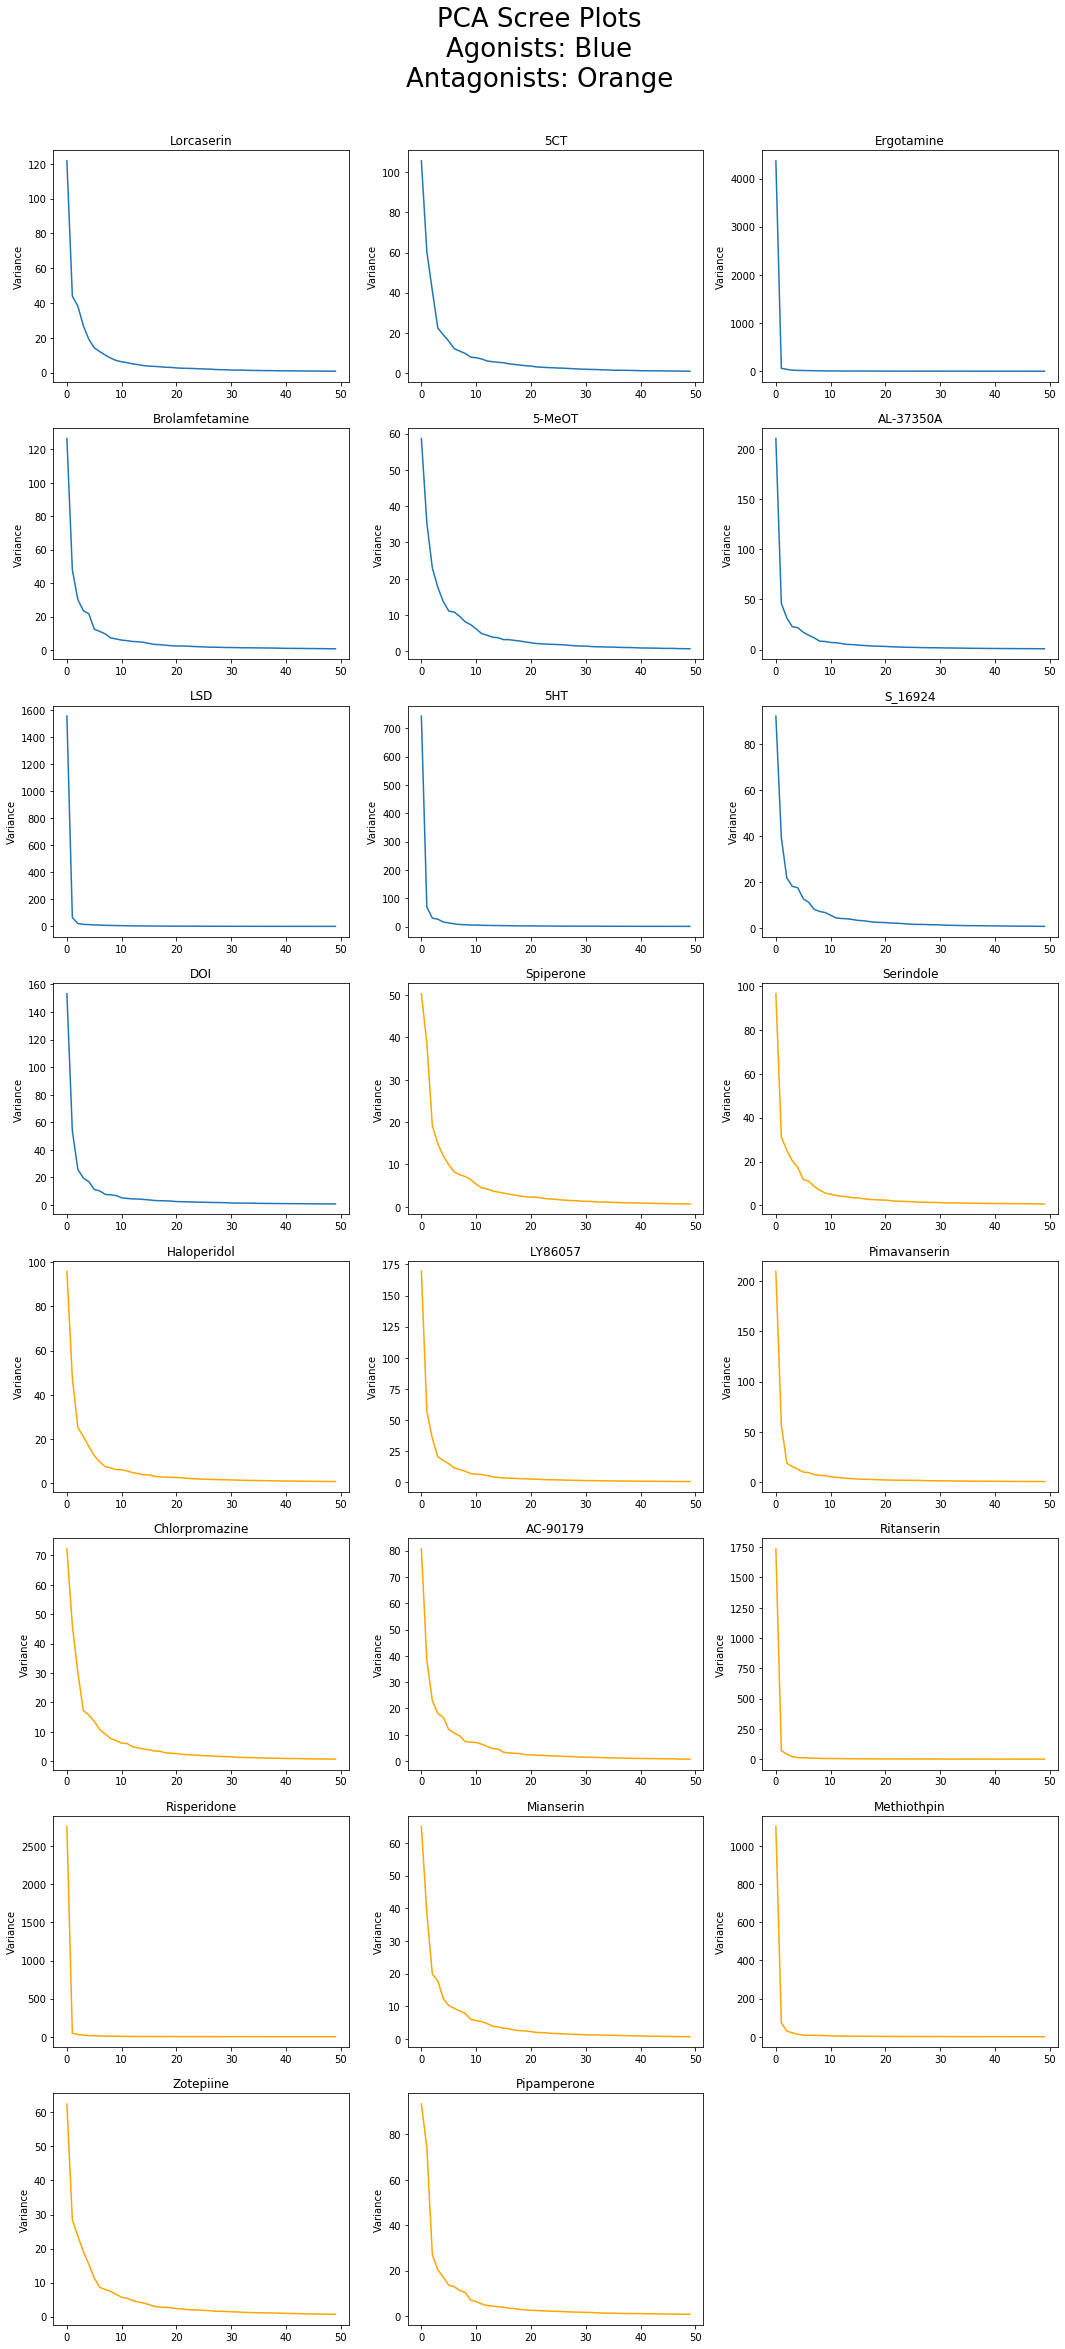

In [21]:
# We create scree plot the top 50 PCs
pcs_on_scree_plot = 50    # Change the number of PCs used on the scree plot

fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(len(which_drug[1].pca_res.variance[:pcs_on_scree_plot])), which_drug[1].pca_res.variance[:pcs_on_scree_plot], label="Variance")
    plt.ylabel("Variance")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(len(which_drug[1].pca_res.variance[:pcs_on_scree_plot])), which_drug[1].pca_res.variance[:pcs_on_scree_plot], label="Variance", color='orange')
    plt.ylabel("Variance")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('PCA Scree Plots\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)

plt.show()

We observe in some cases a relatively "gentle" slope => need of more PCs to express the movements the atoms of the protein make => the movements are more frequent and include more atoms.  

On other cases the slope is steep meaning that no great movements were observed.

These observations are shown on the following plot.

In [16]:
# Get the PCs that give us 50%, 75%, 95% variance for each drug
pca_df = pd.DataFrame(columns=['Drug Name', 'Type', '50% Variance', '75% Variance', '95% Variance'])

def populate_variance_showcase_df(drug_type, inp_df):
    '''
    Creates a DataFrame having for each drug the number of PCs needed in order to have 50%, 75% and 95% variance
    
    Args:
        drug_type (str): 'Agonists' or 'Antagonists'
        inp_df (pd.DataFrame): The column names initialized empty Dataframe or the output of a call of this method
        
    Returns:
        pd.DataFrame: The inp_df in which we appended info about the drug type we specified
    '''
    for which_drug in analysis_actors_dict[drug_type]:
        pca_var_row = pd.DataFrame([[
            which_drug[1].drug_name,
            drug_type,
            np.where(which_drug[1].pca_res.cumulated_variance > 0.5)[0][0] + 1,    # We +1 since the np.where will return
            np.where(which_drug[1].pca_res.cumulated_variance > 0.75)[0][0] + 1,   # the 0 based index of the PC
            np.where(which_drug[1].pca_res.cumulated_variance > 0.95)[0][0] + 1]
        ], columns=['Drug Name', 'Type', '50% Variance', '75% Variance', '95% Variance'])
        inp_df = inp_df.append(pca_var_row, ignore_index=True)
    
    return inp_df
    
    
pca_df = populate_variance_showcase_df('Agonists', pca_df)
pca_df = populate_variance_showcase_df('Antagonists', pca_df)

display(pca_df)

,Drug Name,Type,50% Variance,75% Variance,95% Variance
0,Lorcaserin,Agonists,4,14,106
1,5CT,Agonists,4,16,107
2,Ergotamine,Agonists,1,1,3
3,Brolamfetamine,Agonists,4,15,109
4,5-MeOT,Agonists,6,22,135
5,AL-37350A,Agonists,3,12,90
6,LSD,Agonists,1,1,16
7,5HT,Agonists,1,2,34
8,S_16924,Agonists,5,17,123
9,DOI,Agonists,3,13,105


#### 2D Projection
In order to be able to plot the structural motion we **can project our data on the first 2 PCs** [(ref)](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0112456&type=printable).

**Explanation of the colorbar**: As colorbar color goes from 0 to 1, frames go from 0 to #frames.

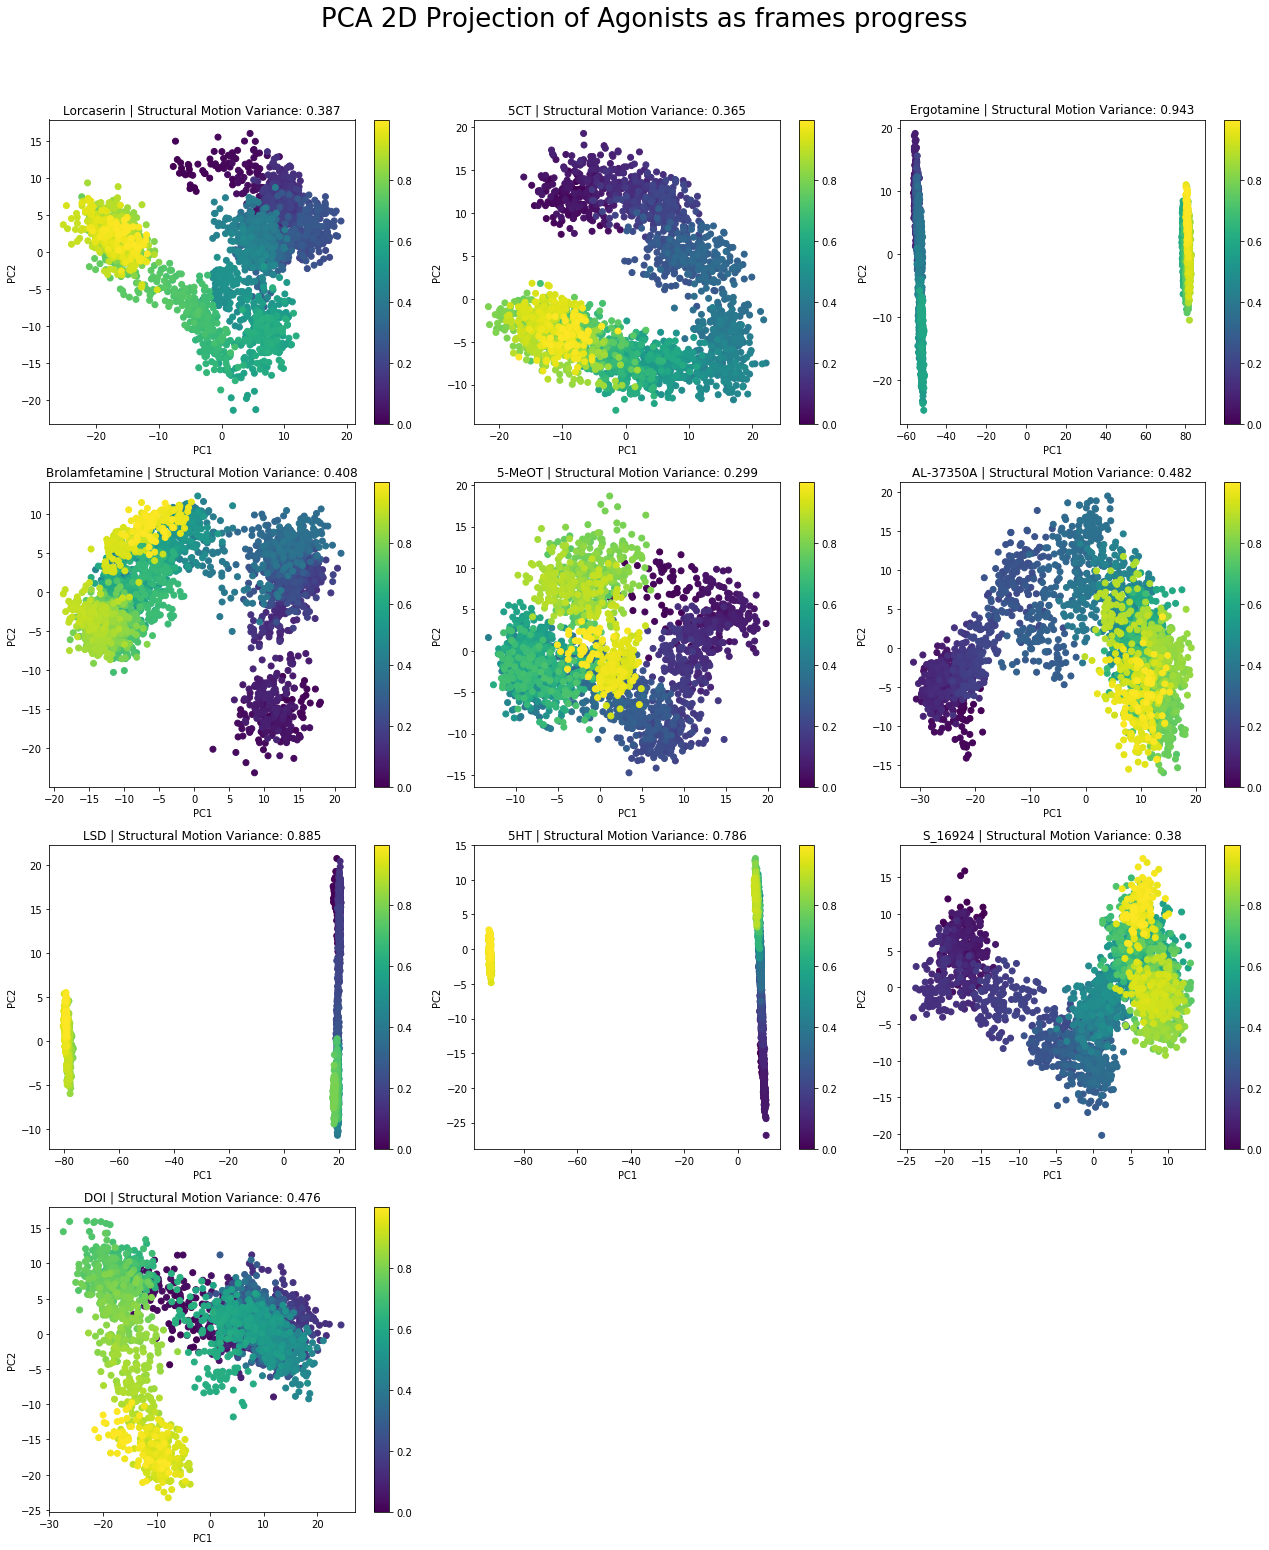

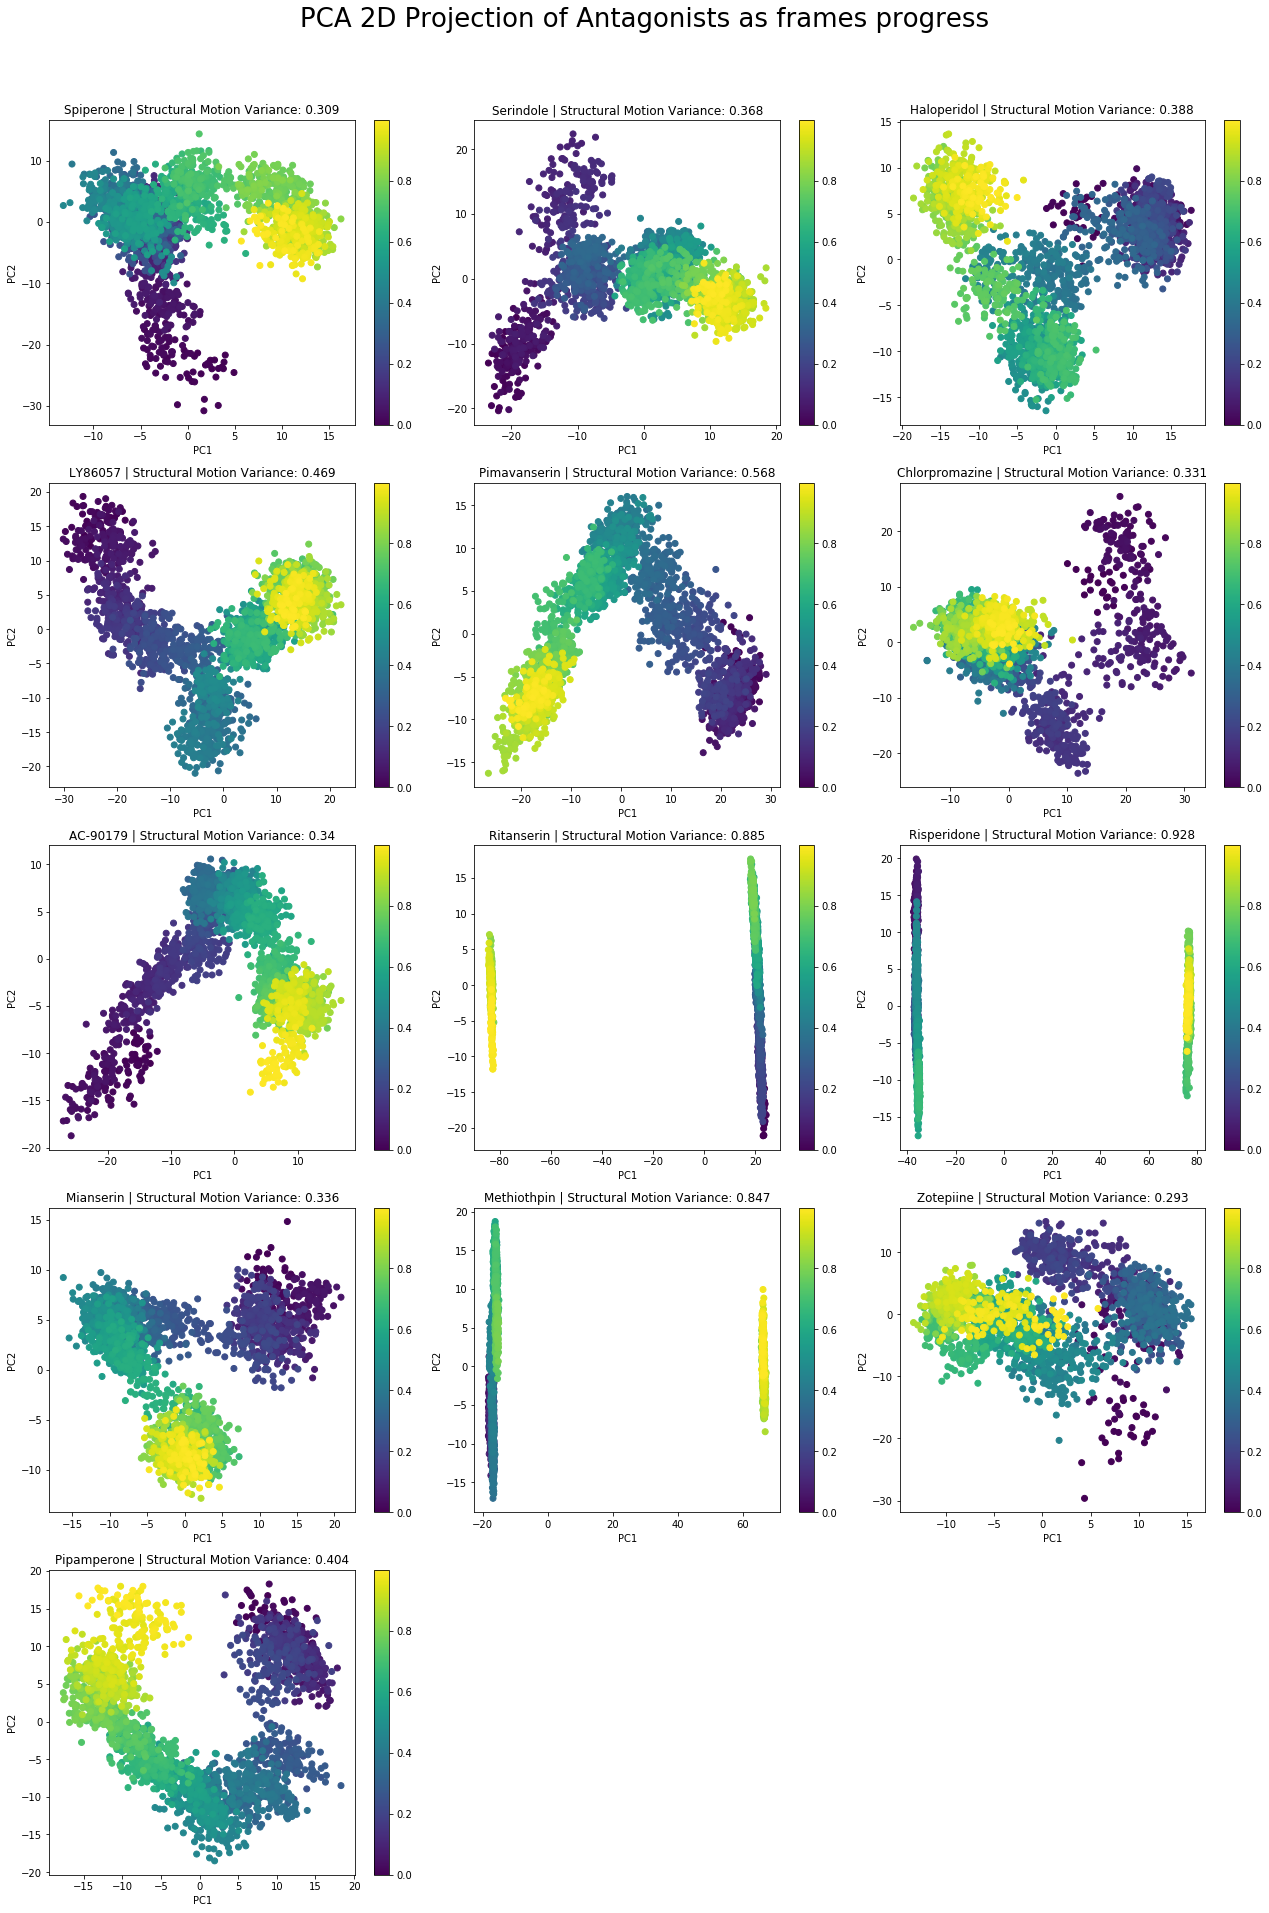

In [17]:
def project_pca_on_2d(drug_type):
    '''
    Plots the 2d projection on the first two PCs of the atom space. The colorbar expresses the progression
    of the frames (color0 -> frame0, color1 -> last_frame).
    The plot is shown inside the function but if need can be easily be changed to return it.
    
    Args:
        drug_type (str): 'Agonists' or 'Antagonists'
    
    '''
    fig = plt.figure(figsize=(18, 40))
    plot_index = 1

    for which_drug in tqdm(analysis_actors_dict[drug_type]):
        atomgroup = which_drug[1].uni.select_atoms('name CA')    # Select the atoms pca was performed on
        pca_space_2D = which_drug[1].pca_res.transform(atomgroup, 2)    # Do the transformation on the selected atoms
        step = 1    # Frames we are skipping for computational reasons (if step == 1 then no frame is skipped)
        
        # Scatter Plotting
        ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
        plt.scatter(pca_space_2D[::step, 0], pca_space_2D[::step, 1], c=np.arange(len(pca_space_2D) / step) / (len(pca_space_2D) / step), marker='o')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title(f'{which_drug[1].drug_name} | Structural Motion Variance: {np.around(which_drug[1].pca_res.cumulated_variance[1], decimals=3)}')
        plt.colorbar()    # Add the colorbar which goes from color0 to color1 as frames progress
        plot_index += 1

    fig.suptitle(f'PCA 2D Projection of {drug_type} as frames progress', fontsize=26, y = 1.03)
    plt.tight_layout()
    plt.show()


project_pca_on_2d('Agonists')    # Plot the agonists projection
project_pca_on_2d('Antagonists') # Plot the antagonists projection

After observing the above plots I had a difficult time to to find any visual difference that would help me, as a human, be able to classify a random drug as an antagonist or agonist.  
For that reason I was thinking of combining some of the features I extracted (mostly RMSF and PCA) and perform unsupervised learning (k-means) and observe if our clusters are similar to the expected labels we already know. (NOT YET IMPLEMENTED) 

## Independent Experiments

On this part of the notebook I will stray from the preceding flow of using the `AnalysisActor` since there is no need for the additional overhead of reading all the trajectory files and performing not needed calculations.  

Technically speaking, each "experiment" can be independently run, without having any local variable from previous (or following) cells. 

### Distance between R3.50 (Arg105) and E6.30 (Glu209) of 5HT2A
